# How to size your bets - The Kelly Rule

he Kelly rule has a long history in gambling because it provides guidance on how much to stake on each of an (infinite) sequence of bets with varying (but favorable) odds to maximize terminal wealth. It was published as A New Interpretation of the Information Rate in 1956 by John Kelly who was a colleague of Claude Shannon's at Bell Labs. He was intrigued by bets placed on candidates at the new quiz show The $64,000 Question, where a viewer on the west coast used the three-hour delay to obtain insider information about the winners. 

Kelly drew a connection to Shannon's information theory to solve for the bet that is optimal for long-term capital growth when the odds are favorable, but uncertainty remains. His rule maximizes logarithmic wealth as a function of the odds of success of each game, and includes implicit bankruptcy protection since log(0) is negative infinity so that a Kelly gambler would naturally avoid losing everything.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path
import random
import numpy as np
from numpy.linalg import inv
from numpy.random import dirichlet
import pandas as pd

from sympy import symbols, solve, log, diff
from scipy.optimize import minimize_scalar, newton, minimize
from scipy.integrate import quad
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体 
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
DATA_STORE = Path('data', 'assets.h5')

## The optimal size of a bet

Kelly began by analyzing games with a binary win-lose outcome. The key variables are:
- b: The odds define the amount won for a \\$1 bet. Odds = 5/1 implies a \\$5 gain if the bet wins, plus recovery of the \\$1 capital.
- p: The probability defines the likelihood of a favorable outcome.
- f: The share of the current capital to bet.
- V: The value of the capital as a result of betting.

The Kelly rule aims to maximize the value's growth rate, G, of infinitely-repeated bets (see Chapter 5 for background).
$$G=\lim_{N\rightarrow\infty}=\frac{1}{N}\log\frac{V_N}{V_0}$$

We can maximize the rate of growth G by maximizing G with respect to f, as illustrated using sympy as follows:

In [6]:
share, odds, probability = symbols('share odds probability')
Value = probability * log(1 + odds * share) + (1 - probability) * log(1 - share)
solve(diff(Value, share), share)

[(odds*probability + probability - 1)/odds]

In [7]:
f, p = symbols('f p')
y = p * log(1 + f) + (1 - p) * log(1 - f)
solve(diff(y, f), f)

[2*p - 1]

## Get S&P 500 Data

In [8]:
with pd.HDFStore(DATA_STORE) as store:
    sp500 = store['sp500/stooq'].close

### Compute Returns & Standard Deviation

In [9]:
monthly_returns = sp500.resample('M').last().pct_change().dropna().to_frame('sp500')

In [10]:
return_params = monthly_returns.sp500.rolling(25).agg(['mean', 'std']).dropna()

In [11]:
return_ci = (return_params[['mean']]
                .assign(lower=return_params['mean'].sub(return_params['std'].mul(2)))
                .assign(upper=return_params['mean'].add(return_params['std'].mul(2))))

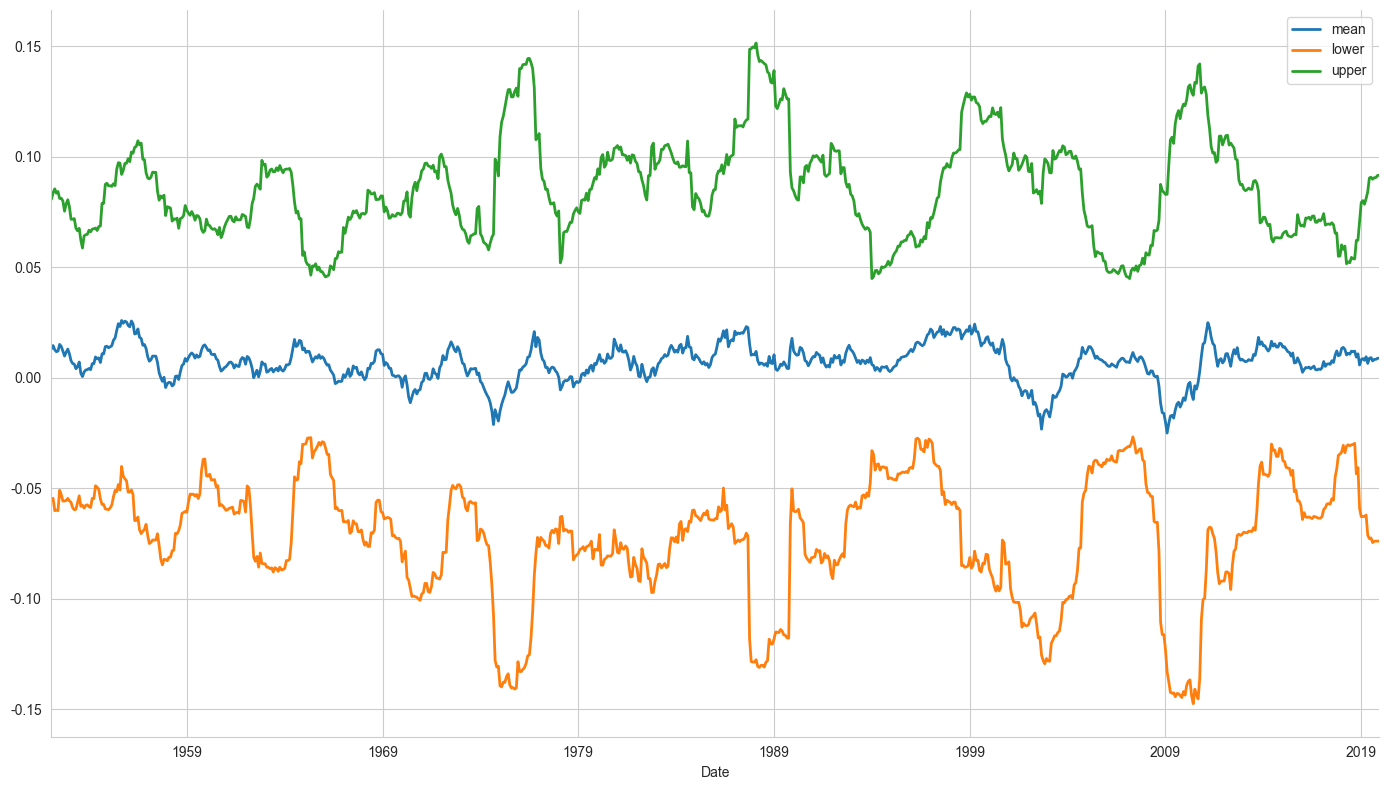

In [12]:
return_ci.plot(lw=2, figsize=(14, 8))
plt.tight_layout()
sns.despine();

### Kelly Rule for a Single Asset - Index Returns

In a financial market context, both outcomes and alternatives are more complex, but the Kelly rule logic does still apply. It was made popular by Ed Thorp, who first applied it profitably to gambling (described in Beat the Dealer) and later started the successful hedge fund Princeton/Newport Partners.

With continuous outcomes, the growth rate of capital is defined by an integrate over the probability distribution of the different returns that can be optimized numerically.
We can solve this expression (see book) for the optimal f* using the `scipy.optimize` module:

In [13]:
def norm_integral(f, mean, std):
    val, er = quad(lambda s: np.log(1 + f * s) * norm.pdf(s, mean, std), 
                               mean - 3 * std, 
                               mean + 3 * std)
    return -val

In [14]:
def norm_dev_integral(f, mean, std):
    val, er = quad(lambda s: (s / (1 + f * s)) * norm.pdf(s, mean, std), m-3*std, mean+3*std)
    return val

In [15]:
def get_kelly_share(data):
    solution = minimize_scalar(norm_integral, 
                        args=(data['mean'], data['std']), 
                        bounds=[0, 2], 
                        method='bounded') 
    return solution.x

In [16]:
monthly_returns['f'] = return_params.apply(get_kelly_share, axis=1)

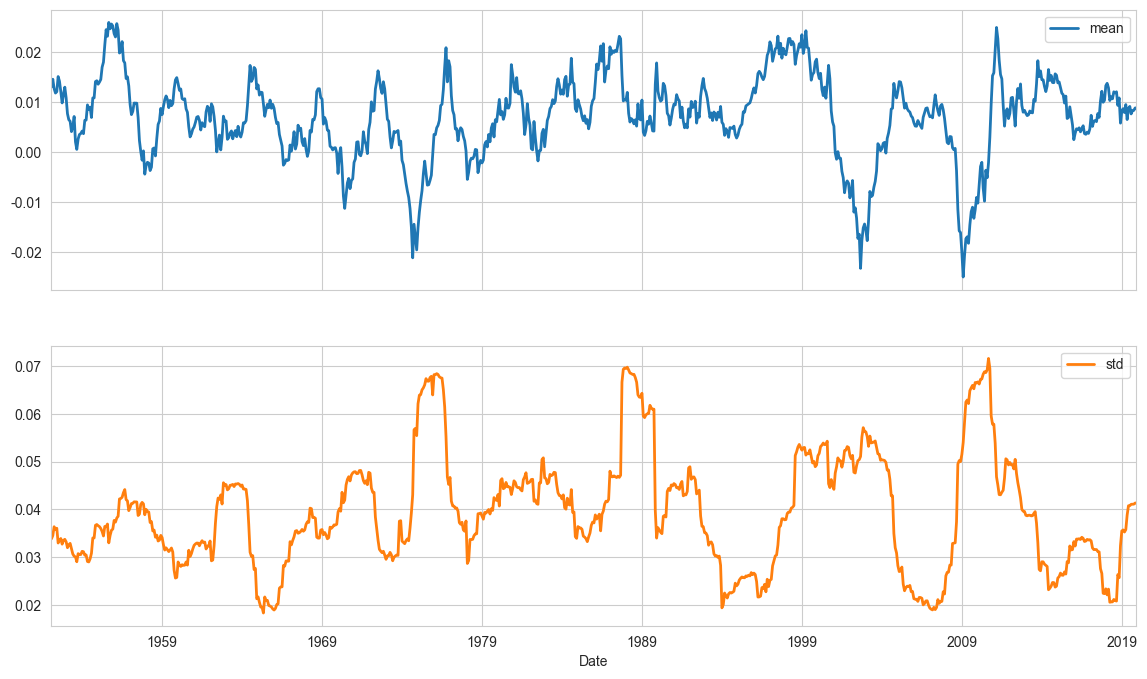

In [17]:
return_params.plot(subplots=True, lw=2, figsize=(14, 8));

In [18]:
monthly_returns.tail()

,sp500,f
Date,,
2019-08-31,-0.018092,1.999996
2019-09-30,0.017181,1.999996
2019-10-31,0.020432,1.999996
2019-11-30,0.034047,1.999996
2019-12-31,0.028590,1.999996


### Performance Evaluation

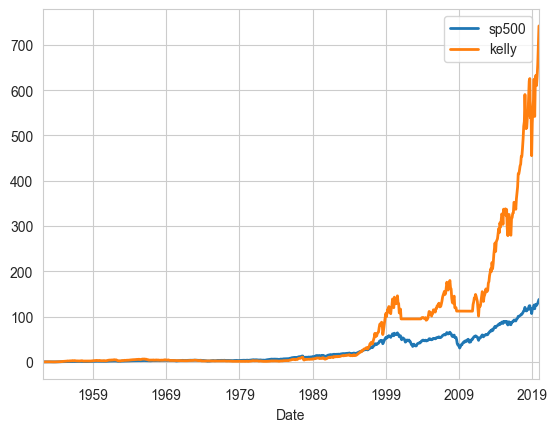

In [19]:
(monthly_returns[['sp500']]
 .assign(kelly=monthly_returns.sp500.mul(monthly_returns.f.shift()))
 .dropna()
 .loc['1900':]
 .add(1)
 .cumprod()
 .sub(1)
 .plot(lw=2));

In [20]:
monthly_returns.f.describe()

count    815.000000
mean       1.575104
std        0.766200
min        0.000004
25%        1.612795
50%        1.999996
75%        1.999996
max        1.999996
Name: f, dtype: float64

In [21]:
return_ci.tail()

,mean,lower,upper
Date,,,
2019-08-31,0.007623,-0.074537,0.089783
2019-09-30,0.008288,-0.073903,0.090479
2019-10-31,0.008333,-0.073884,0.090550
2019-11-30,0.008808,-0.073878,0.091493
2019-12-31,0.008828,-0.073878,0.091534


### Compute Kelly Fraction

In [22]:
return_params.tail()

,mean,std
Date,,
2019-08-31,0.007623,0.041080
2019-09-30,0.008288,0.041095
2019-10-31,0.008333,0.041109
2019-11-30,0.008808,0.041343
2019-12-31,0.008828,0.041353


In [23]:
m = .008828
s = .041343

In [24]:
# Option 1: minimize the expectation integral
sol = minimize_scalar(norm_integral, args=(m, s), bounds=[0., 2.], method='bounded')
print('Optimal Kelly fraction: {:.4f}'.format(sol.x))

Optimal Kelly fraction: 2.0000


In [25]:
# Option 2: take the derivative of the expectation and make it null
x0 = newton(norm_dev_integral, .1, args=(m, s))
print('Optimal Kelly fraction: {:.4f}'.format(x0))

Optimal Kelly fraction: 5.0982


## Kelly Rule for Multiple Assets

We will use an example with various equities. [E. Chan (2008)](https://www.amazon.com/Quantitative-Trading-Build-Algorithmic-Business/dp/0470284889) illustrates how to arrive at a multi-asset application of the Kelly Rule, and that the result is equivalent to the (potentially levered) maximum Sharpe ratio portfolio from the mean-variance optimization. 

The computation involves the dot product of the precision matrix, which is the inverse of the covariance matrix, and the return matrix:

In [26]:
with pd.HDFStore(DATA_STORE) as store:
    sp500_stocks = store['sp500/stocks'].index 
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker').filter(sp500_stocks)

In [27]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14277 entries, 1962-01-02 to 2018-03-27
Columns: 458 entries, MMM to ZTS
dtypes: float64(458)
memory usage: 50.0 MB


In [28]:
monthly_returns = prices.loc['1988':'2017'].resample('M').last().pct_change().dropna(how='all').dropna(axis=1)
stocks = monthly_returns.columns
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 1988-02-29 to 2017-12-31
Freq: M
Columns: 195 entries, MMM to XEL
dtypes: float64(195)
memory usage: 549.7 KB


### Compute Precision Matrix

In [ ]:
mean_returns = monthly_returns.mean()
cov_matrix = monthly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov_matrix),index=stocks,columns=stocks)
kelly_wt = precision_matrix.dot(mean_returns).values

In [29]:
cov = monthly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov), index=stocks, columns=stocks)

In [30]:
cov

ticker,MMM,AOS,ABT,ABMD,ADM,ADBE,ADP,AFL,APD,ALK,...,WMT,WEC,WFC,WST,WDC,WY,WHR,WMB,GWW,XEL
ticker,,,,,,,,,,,,,,,,,,,,,
MMM,0.003103,0.001881,0.000582,0.001578,0.001237,0.002122,0.001072,0.001605,0.002182,0.001299,...,0.000790,0.000482,0.001655,0.000819,0.001464,0.002216,0.002527,0.001164,0.001560,0.000662
AOS,0.001881,0.008950,0.000729,0.000961,0.000934,0.001830,0.001005,0.001674,0.002174,0.001562,...,0.000782,0.000337,0.001788,0.001704,0.001612,0.002534,0.003062,0.001678,0.001392,0.000457
ABT,0.000582,0.000729,0.003169,0.000559,0.001050,0.001260,0.000833,0.000940,0.000917,0.000820,...,0.000689,0.000472,0.001210,0.000337,0.000958,0.000827,0.001131,0.000963,0.000607,0.000581
ABMD,0.001578,0.000961,0.000559,0.029386,0.000694,0.004249,0.001361,0.002261,0.002017,0.002267,...,-0.000159,0.000668,0.001591,0.001743,0.001971,0.001661,0.002336,0.004947,0.001131,0.001105
ADM,0.001237,0.000934,0.001050,0.000694,0.006072,0.000648,0.001313,0.001308,0.001666,0.001478,...,0.000896,0.000696,0.001049,0.000944,0.000722,0.001354,0.001534,0.001780,0.001530,0.000975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WY,0.002216,0.002534,0.000827,0.001661,0.001354,0.003280,0.001839,0.002764,0.002806,0.002257,...,0.001595,0.000539,0.002904,0.001596,0.002865,0.006342,0.004309,0.002304,0.002490,0.000691
WHR,0.002527,0.003062,0.001131,0.002336,0.001534,0.003833,0.001618,0.003202,0.003430,0.002837,...,0.001493,0.000549,0.003659,0.002120,0.003727,0.004309,0.009795,0.002576,0.002629,0.000715
WMB,0.001164,0.001678,0.000963,0.004947,0.001780,0.004258,0.001648,0.002439,0.002231,0.001612,...,0.000181,0.000675,0.002167,0.001591,0.003362,0.002304,0.002576,0.012834,0.001342,0.002335


In [31]:
precision_matrix

ticker,MMM,AOS,ABT,ABMD,ADM,ADBE,ADP,AFL,APD,ALK,...,WMT,WEC,WFC,WST,WDC,WY,WHR,WMB,GWW,XEL
ticker,,,,,,,,,,,,,,,,,,,,,
MMM,1786.905012,-23.474394,173.367998,-32.533608,-89.982581,50.940656,36.463102,-13.428098,-117.180077,43.391509,...,11.602474,-218.398728,-37.484261,27.032676,-37.451377,-251.317649,-57.415291,18.249238,67.116241,-104.494597
AOS,-23.474394,359.136465,-97.783475,3.312805,17.461007,32.554760,-54.926731,13.932328,20.634607,62.004854,...,-39.504694,24.729034,12.978015,-55.576524,6.798476,12.782974,-33.753207,-18.318491,47.425094,49.576531
ABT,173.367998,-97.783475,1251.012736,-0.185685,-90.265927,-101.293924,103.547215,-7.121110,49.378077,17.483128,...,-6.183205,88.544260,-76.195135,119.997245,-76.283390,-120.732810,43.773804,-32.222696,6.661844,99.291200
ABMD,-32.533608,3.312805,-0.185685,94.505412,-22.448087,-21.546870,-17.568580,-9.070327,-48.159757,-5.055254,...,35.648380,-3.879622,-2.237164,-17.472252,0.870921,15.958102,6.097318,-43.416720,-13.799945,56.923250
ADM,-89.982581,17.461007,-90.265927,-22.448087,516.697512,43.732730,-51.865966,2.716248,28.113571,2.511842,...,-99.848220,-1.676749,2.373198,-39.207144,35.251919,32.997710,-74.398319,-8.624652,-50.255937,-57.802176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WY,-251.317649,12.782974,-120.732810,15.958102,32.997710,-37.311831,-13.445545,10.257235,3.782109,-21.109993,...,-155.138349,-56.250644,31.172485,-15.641346,33.071060,882.866874,-18.590955,-2.377577,-27.003980,61.741493
WHR,-57.415291,-33.753207,43.773804,6.097318,-74.398319,-60.835411,120.907398,51.509673,14.495769,10.279220,...,61.609280,-14.213387,-38.468536,59.796907,-44.012261,-18.590955,563.270465,-13.863524,78.327458,98.317318
WMB,18.249238,-18.318491,-32.222696,-43.416720,-8.624652,14.851659,-20.036720,15.820650,85.514935,1.749199,...,12.321750,16.336046,-0.135201,47.004128,22.871020,-2.377577,-13.863524,334.374758,31.387238,-180.948788


In [32]:
kelly_allocation = monthly_returns.mean().dot(precision_matrix)

In [33]:
kelly_allocation

ticker
MMM     3.846225
AOS     3.077243
ABT    -0.789968
ABMD    0.585594
ADM     0.421277
          ...   
WY     -3.108244
WHR    -1.130703
WMB    -2.669539
GWW    -0.934099
XEL    -6.786684
Length: 195, dtype: float64

In [34]:
kelly_allocation.describe()

count    195.000000
mean       0.248868
std        3.335394
min       -9.833097
25%       -1.632686
50%        0.284117
75%        2.277600
max        8.876720
dtype: float64

In [35]:
kelly_allocation.sum()

48.52919183158795

### Largest Portfolio Allocation

The plot shows the tickers that receive an allocation weight > 5x their value:

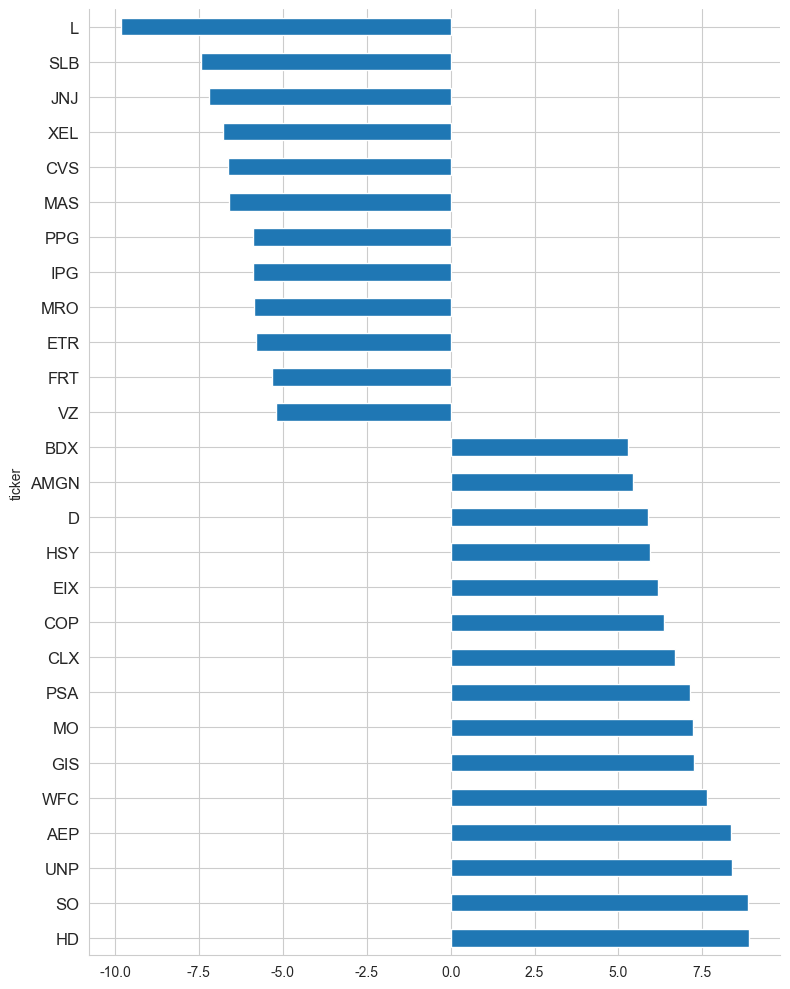

In [36]:
kelly_allocation[kelly_allocation.abs()>5].sort_values(ascending=False).plot.barh(figsize=(8, 10))
plt.yticks(fontsize=12)
sns.despine()
plt.tight_layout();

### Performance vs SP500

The Kelly rule does really well. But it has also been computed from historical data..

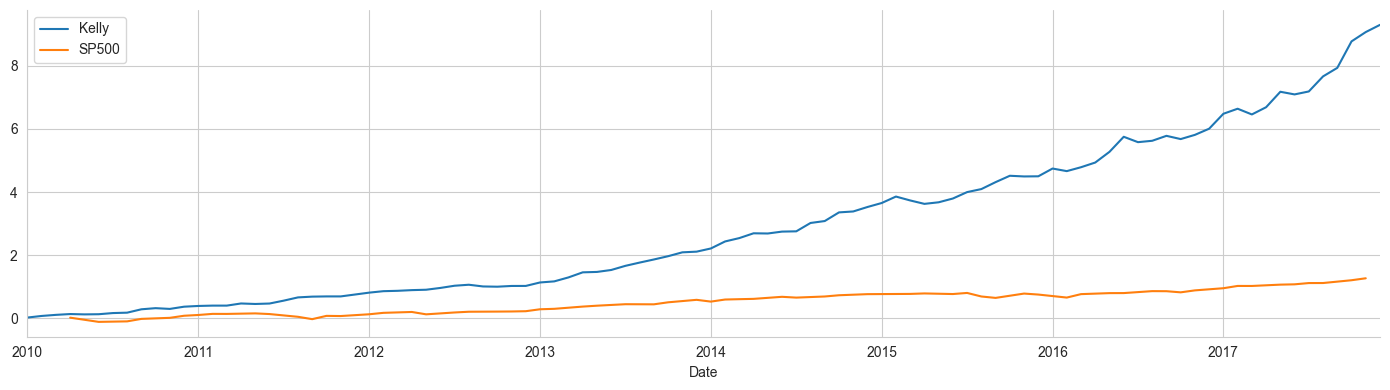

In [37]:
ax = monthly_returns.loc['2010':].mul(kelly_allocation.div(kelly_allocation.sum())).sum(1).to_frame('Kelly').add(1).cumprod().sub(1).plot(figsize=(14,4));
sp500.filter(monthly_returns.loc['2010':].index).pct_change().add(1).cumprod().sub(1).to_frame('SP500').plot(ax=ax, legend=True)
plt.tight_layout()
sns.despine();

## <font color='red'>沪深300数据</font>

In [38]:
DATA_STORE = Path('Adata', 'assets.h5')

In [39]:
with pd.HDFStore(DATA_STORE) as store:
    hs300 = store['csmar/hsindex'].close

In [40]:
weekly_returns = hs300.resample('W').last().pct_change().dropna().to_frame('hs300')

In [41]:
return_params = weekly_returns.hs300.rolling(25).agg(['mean', 'std']).dropna()

In [42]:
return_ci = (return_params[['mean']]
                .assign(lower=return_params['mean'].sub(return_params['std'].mul(2)))
                .assign(upper=return_params['mean'].add(return_params['std'].mul(2))))

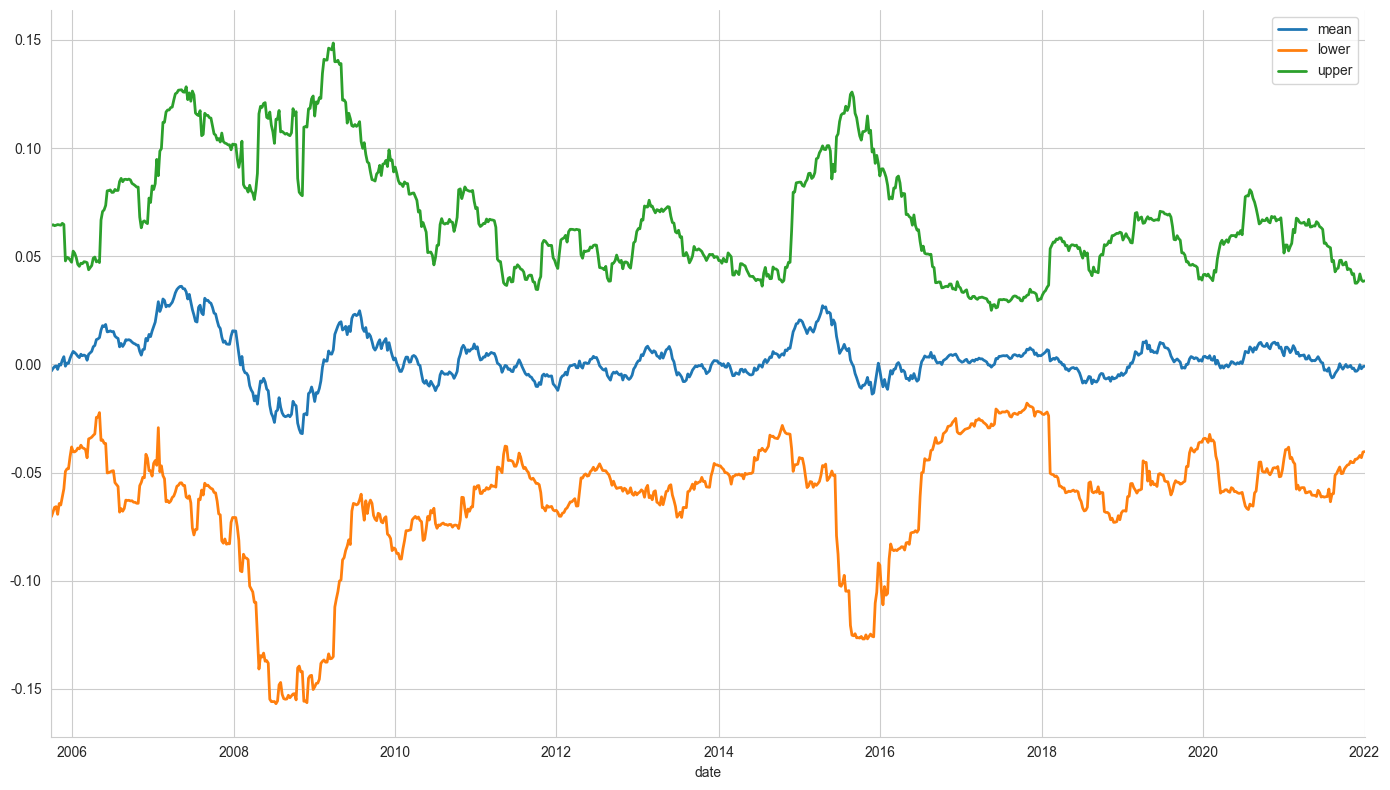

In [43]:
return_ci.plot(lw=2, figsize=(14, 8))
plt.tight_layout()
sns.despine();

In [44]:
weekly_returns['f'] = return_params.apply(get_kelly_share, axis=1)

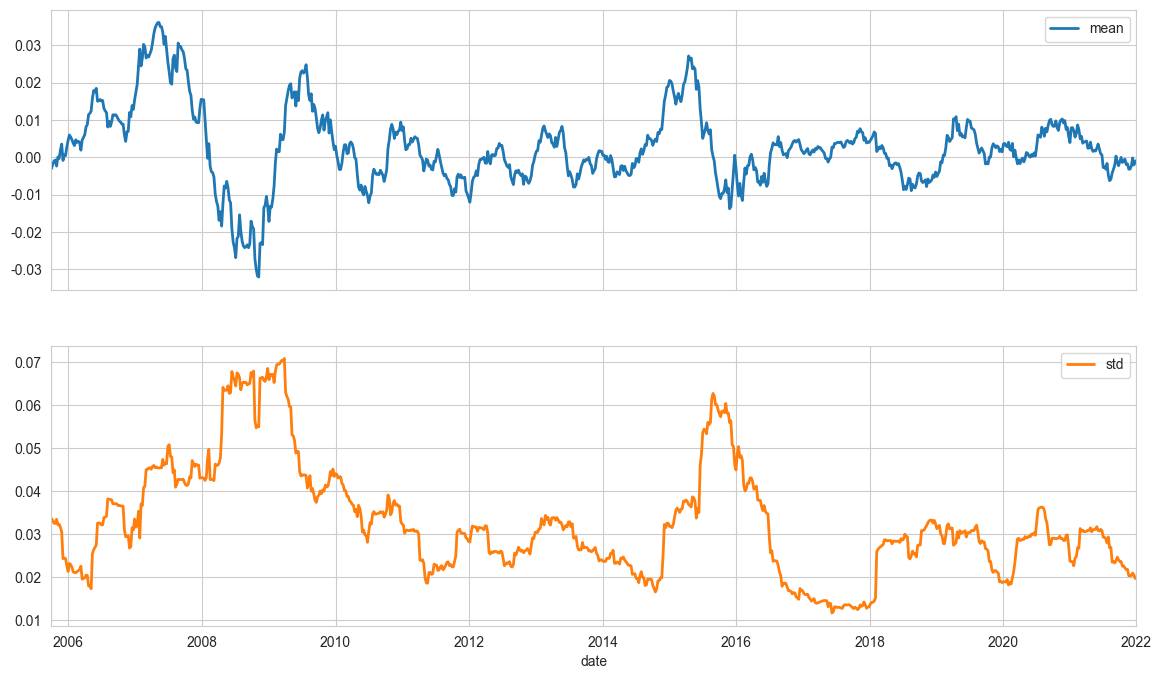

In [45]:
return_params.plot(subplots=True, lw=2, figsize=(14, 8));

In [46]:
weekly_returns.tail()

,hs300,f
date,,
2021-12-05,0.008414,0.000004
2021-12-12,0.031442,0.000004
2021-12-19,-0.019853,0.000004
2021-12-26,-0.006744,0.000004
2022-01-02,0.003866,0.000004


In [83]:
var = monthly_returns.var()
risk_parity_weights = var/var.sum()

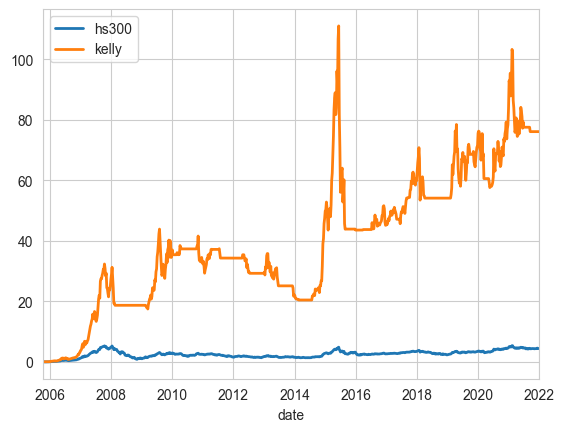

In [47]:
(weekly_returns[['hs300']]
 .assign(kelly=weekly_returns.hs300.mul(weekly_returns.f.shift()))
 .dropna()
 .add(1)
 .cumprod()
 .sub(1)
 .plot(lw=2));

In [48]:
weekly_returns.f.describe()

count    849.000000
mean       1.114003
std        0.965867
min        0.000004
25%        0.000004
50%        1.999996
75%        1.999996
max        1.999996
Name: f, dtype: float64

In [49]:
return_ci.head()

,mean,lower,upper
date,,,
2005-10-02,-0.003042,-0.070354,0.064269
2005-10-09,-0.001872,-0.068295,0.064551
2005-10-16,-0.000983,-0.066090,0.064124
2005-10-23,-0.000716,-0.065773,0.064341
2005-10-30,-0.002338,-0.069315,0.064639


### <font color='red'>沪深300混合资产</font>

In [50]:
with pd.HDFStore(DATA_STORE) as store:
    prices = store['csmar/aprices'].adj_close.unstack('name').sample(n=30, axis=1)

In [51]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2019-01-02 to 2021-12-31
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   山东黄金    729 non-null    float64
 1   视源股份    730 non-null    float64
 2   红塔证券    602 non-null    float64
 3   三峡能源    139 non-null    float64
 4   云南白药    720 non-null    float64
 5   特变电工    730 non-null    float64
 6   兖矿能源    730 non-null    float64
 7   华兰生物    730 non-null    float64
 8   万科A     730 non-null    float64
 9   恒力石化    730 non-null    float64
 10  农业银行    730 non-null    float64
 11  杭州银行    730 non-null    float64
 12  新华保险    730 non-null    float64
 13  安克创新    331 non-null    float64
 14  中国铁建    730 non-null    float64
 15  中国银行    730 non-null    float64
 16  天坛生物    730 non-null    float64
 17  华侨城A    730 non-null    float64
 18  中泰证券    387 non-null    float64
 19  坚朗五金    730 non-null    float64
 20  宝丰能源    643 non-null    float64
 21  北新建材    730 non-null

In [52]:
weekly_returns = prices.loc['2019':'2021'].resample('W').last().pct_change().dropna(how='all').dropna(axis=1)
stocks = weekly_returns.columns
weekly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156 entries, 2019-01-13 to 2022-01-02
Freq: W-SUN
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   山东黄金    156 non-null    float64
 1   视源股份    156 non-null    float64
 2   云南白药    156 non-null    float64
 3   特变电工    156 non-null    float64
 4   兖矿能源    156 non-null    float64
 5   华兰生物    156 non-null    float64
 6   万科A     156 non-null    float64
 7   恒力石化    156 non-null    float64
 8   农业银行    156 non-null    float64
 9   杭州银行    156 non-null    float64
 10  新华保险    156 non-null    float64
 11  中国铁建    156 non-null    float64
 12  中国银行    156 non-null    float64
 13  天坛生物    156 non-null    float64
 14  华侨城A    156 non-null    float64
 15  坚朗五金    156 non-null    float64
 16  北新建材    156 non-null    float64
 17  福耀玻璃    156 non-null    float64
 18  中国建筑    156 non-null    float64
 19  中国太保    156 non-null    float64
 20  深南电路    156 non-null    float64
dtypes: float

In [53]:
weekly_returns.head()

name,山东黄金,视源股份,云南白药,特变电工,兖矿能源,华兰生物,万科A,恒力石化,农业银行,杭州银行,...,中国铁建,中国银行,天坛生物,华侨城A,坚朗五金,北新建材,福耀玻璃,中国建筑,中国太保,深南电路
date,,,,,,,,,,,,,,,,,,,,,
2019-01-13,-0.019008,0.010302,0.039042,0.015110,-0.010309,-0.011513,0.014842,-0.003666,-0.016713,-0.005284,...,-0.027076,-0.013966,-0.012257,0.019576,0.012440,0.038075,0.037736,-0.006981,-0.037957,0.113595
2019-01-20,-0.030542,0.018460,0.064569,-0.021651,0.055556,0.061469,0.018182,-0.033848,0.014164,0.010624,...,0.004638,0.008499,-0.012410,-0.008000,0.041588,0.022145,0.018182,0.050967,0.069943,0.071370
2019-01-27,0.008130,0.001208,-0.003186,0.002766,-0.032895,0.026821,0.013199,0.001523,0.025140,0.002628,...,-0.063712,0.016854,0.040838,0.016129,-0.022686,0.073121,0.001742,0.011706,0.012068,0.024323
2019-02-03,0.038306,0.070690,0.034897,-0.004138,0.030612,0.024043,0.060536,0.003042,0.013624,0.022280,...,0.000000,0.016574,0.040241,0.015873,0.008357,0.030915,0.020435,0.013223,0.022855,0.072842
2019-02-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [54]:
cov = weekly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov), index=stocks, columns=stocks)

In [55]:
kelly_allocation = weekly_returns.mean().dot(precision_matrix)

In [56]:
kelly_allocation.describe()

count    21.000000
mean      0.106552
std       2.630936
min      -8.674078
25%      -1.117068
50%       0.355676
75%       1.628376
max       3.608159
dtype: float64

In [57]:
kelly_allocation.sum()

2.2375842562221195

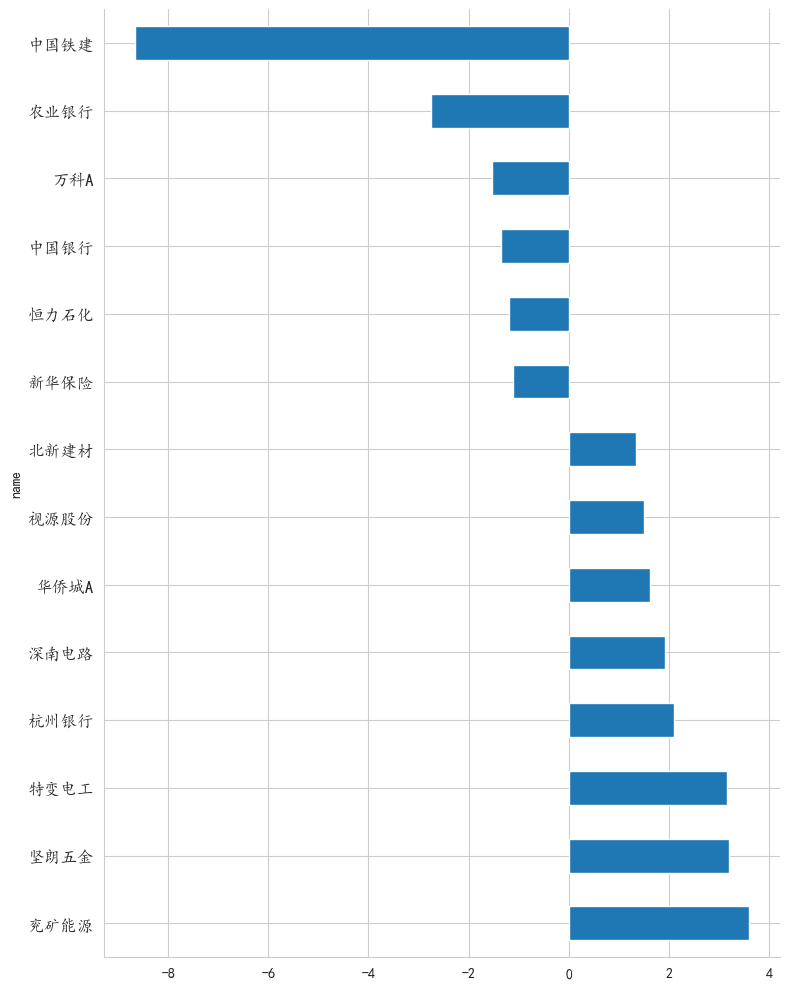

In [61]:
kelly_allocation[kelly_allocation.abs()>1].sort_values(ascending=False).plot.barh(figsize=(8, 10))
plt.yticks(fontsize=12)
sns.despine()
plt.tight_layout();

In [71]:
kelly_weekly_returns = weekly_returns.loc['2019':].mul(kelly_allocation.div(kelly_allocation.sum())).sum(1).to_frame('Kelly')#.add(1).cumprod().sub(1)
kelly_weekly_returns

,Kelly
date,
2019-01-13,0.325049
2019-01-20,0.172097
2019-01-27,0.197796
2019-02-03,0.132564
2019-02-10,0.000000
...,...
2021-12-05,-0.122325
2021-12-12,0.270609
2021-12-19,0.173891


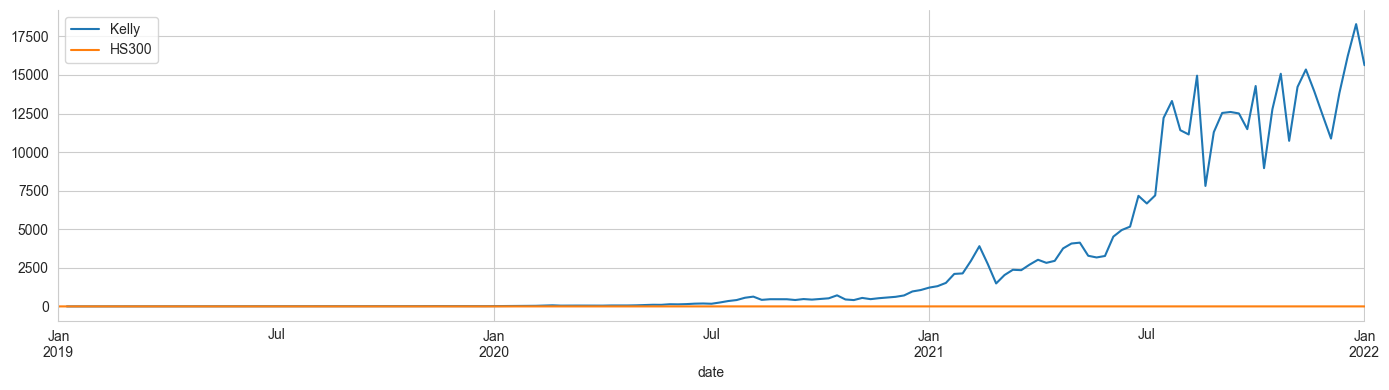

In [59]:
ax = weekly_returns.loc['2019':].mul(kelly_allocation.div(kelly_allocation.sum())).sum(1).to_frame('Kelly').add(1).cumprod().sub(1).plot(figsize=(14,4));
hs300.loc['2019':].pct_change().add(1).cumprod().sub(1).to_frame('HS300').plot(ax=ax, legend=True)
plt.tight_layout()
sns.despine();